# Logistic regression modeling and interpretation using Yelp reviews

In [1]:
%matplotlib inline
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels import graphics
from patsy import dmatrices
# load R  # install rpy2 through anaconda environment if needed.
%load_ext rpy2.ipython   

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

C:\Users\ML\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Read data

In [2]:
reviews = pd.read_csv('data/reviews.csv')

## <span style="color:blue">   Logistic regression Run #1

### Feature inportance will be checked with scaled input data

# Log input data

In [3]:
# reviews.loc[:,['photos','friends','numSentence','numWords','reviews','totSentiment']] = np.log(reviews.loc[:,['photos','friends','numSentence','numWords','reviews','totSentiment']]+2)

# Balance the data

In [4]:
n_not_recomended = (reviews['regular'] == 0).sum()
reg_reviews = reviews[reviews['regular'] == 1].sample(n=n_not_recomended, random_state=1)
not_reviews = reviews[reviews['regular'] == 0].sample(n=n_not_recomended, random_state=1)

balanced_reviews = reg_reviews.append(not_reviews).sample(frac=1.)
len(balanced_reviews), len(reviews)

(54114, 252508)

# Normalize data

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

y = balanced_reviews['regular']
X = balanced_reviews.copy()
del X['regular']
columns = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columns)

# Fit a linear model and Analysis on coefficients

R2 score 0.264015102976


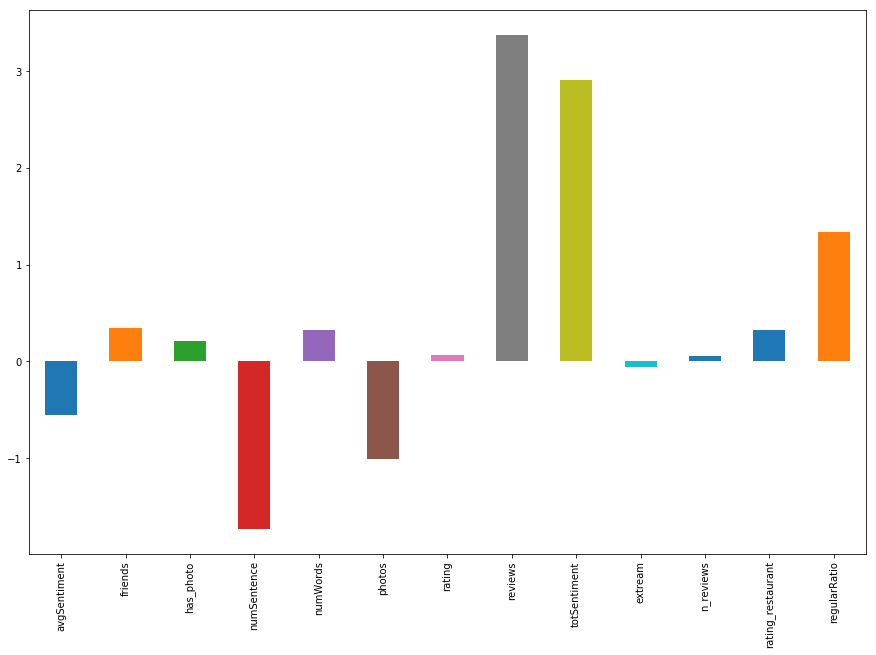

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

clf = LinearRegression()
clf.fit(X, y)
pd.Series(clf.coef_, index=columns).plot(kind='bar');

y_pred = clf.predict(X)
print('R2 score', r2_score(y, y_pred))

# Same but with LogisticRegression

R2 score -0.0464574786562


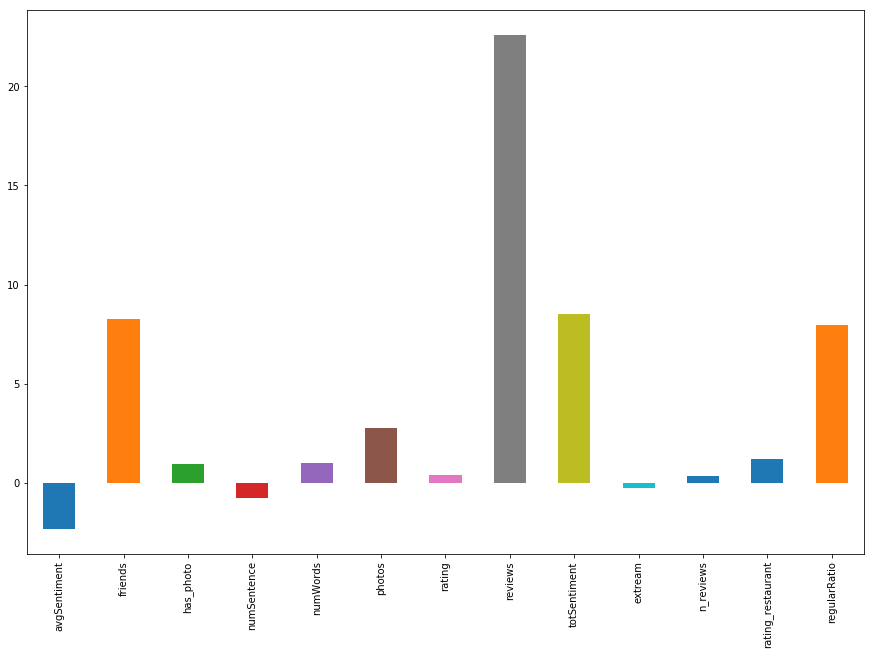

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

clf2 = LogisticRegression()
clf2.fit(X, y)
pd.Series(clf2.coef_[0], index=columns).plot(kind='bar');

y_pred = clf2.predict(X)

print('R2 score', r2_score(y, y_pred))

# TODO interpret the result

## <span style="color:blue"> Interpretation of logistic regression equation
    
- Each predictor variable will be explored from the min to the max values
- Rest of the predictor values will remain as a mean constant value


### Probability of a review being 'regular' w/ review value change

In [8]:
bad_features = ['rating', 'extream', 'n_reviews']

weights = pd.Series(clf.coef_, index=columns)
weights = weights[~weights.index.isin(bad_features)]
weights

avgSentiment        -0.556273
friends              0.346457
has_photo            0.207883
numSentence         -1.732665
numWords             0.319778
photos              -1.012846
reviews              3.373824
totSentiment         2.903603
rating_restaurant    0.322338
regularRatio         1.339727
dtype: float64


### Model (regression): 

regular_hat = -0.788*avgSentiment +0.182*log_friends +0.065*has_photo -2.58*log_numSentence +0.867*log_numWords +0.016*log_photos +1.00*log_reviews +2.34*log_totSentiment +0.323*rating_restaurant +0.997*regularRatio

### Model interpretation:
TODO

# T-Test: Significance of Coefficients Test

In [15]:
data = X.copy()
data = data.reset_index(drop=True)
y = y.reset_index(drop=True)
data['regular'] = y
# data = pd.concat([X,y], axis = 1)
model = smf.ols("regular ~ avgSentiment + np.log(1+friends)+has_photo+np.log(1+numSentence)+np.log(1+numWords)+np.log(1+photos)+np.log(1+reviews)+np.log(1+totSentiment)+rating_restaurant+regularRatio", data).fit()

print("Model parameter :\n", model.params)
print("\nModel summary :\n", model.summary())

Model parameter :
 Intercept                  -0.979023
avgSentiment               -0.534836
np.log(1 + friends)         0.514319
has_photo                   0.211248
np.log(1 + numSentence)    -2.377087
np.log(1 + numWords)        0.507626
np.log(1 + photos)         -1.552343
np.log(1 + reviews)         4.478504
np.log(1 + totSentiment)    3.566283
rating_restaurant           0.424951
regularRatio                1.296912
dtype: float64

Model summary :
                             OLS Regression Results                            
Dep. Variable:                regular   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1975.
Date:                Wed, 02 May 2018   Prob (F-statistic):               0.00
Time:                        18:17:11   Log-Likelihood:                -30854.
No. Observations:               54114   AIC:                       

# Q-Q plot

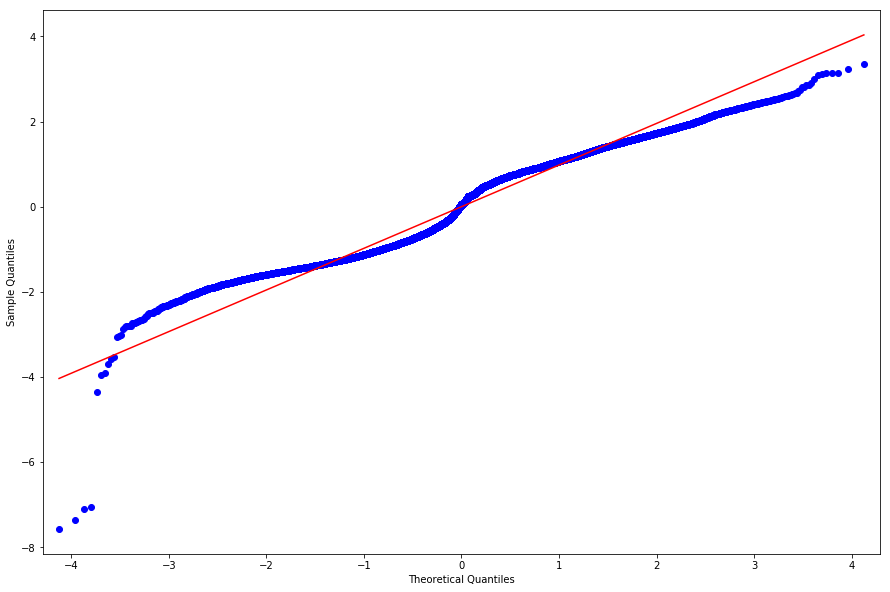

In [18]:
# residuals
residuals = model.resid
line = 'r' # '45' 's' 'q' 'r'
graphics.gofplots.qqplot(residuals, dist=stats.t, line=line, fit=True);

# Residual plot

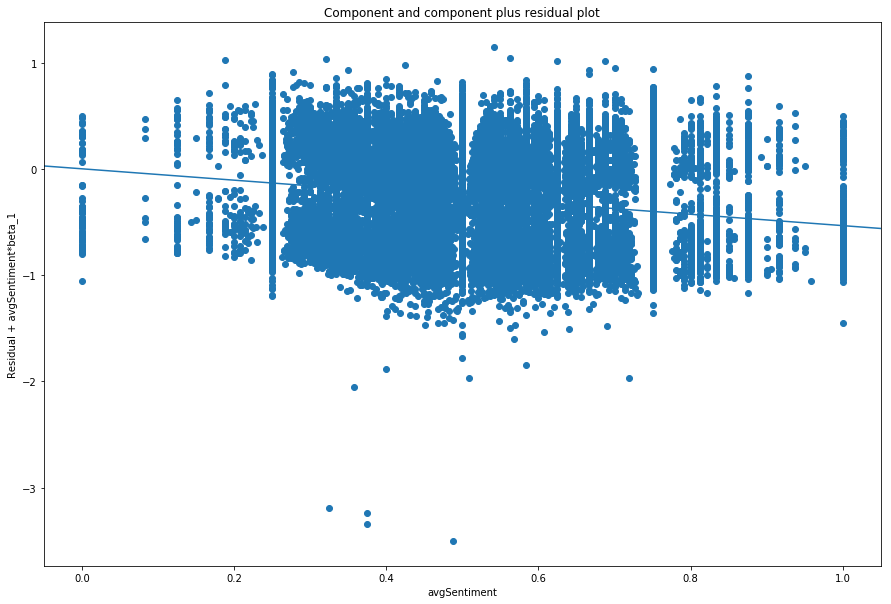

In [19]:
sm.graphics.plot_ccpr(model, exog_idx=1);

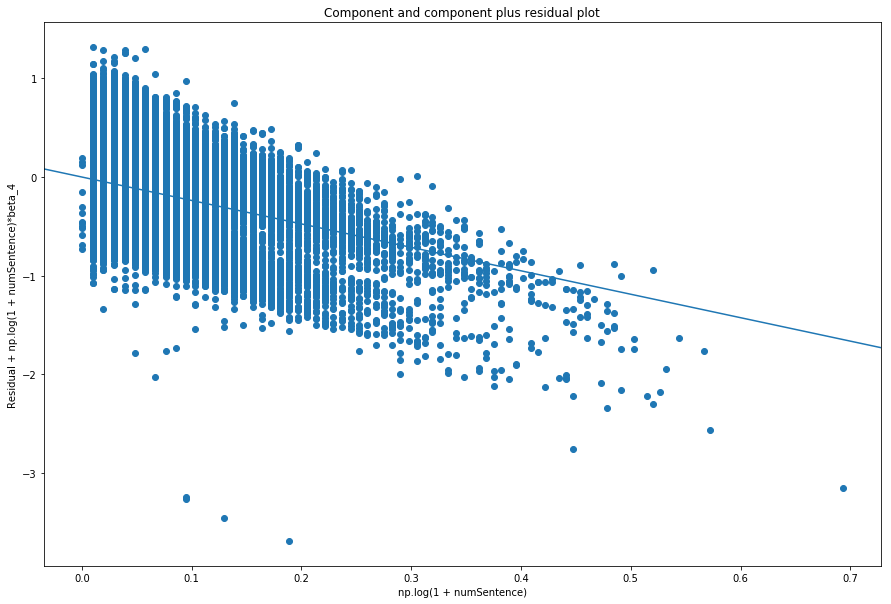

In [27]:
sm.graphics.plot_ccpr(model, exog_idx=4);

# Cook's distance

In [ ]:
influence = model.get_influence()
influence_summary = influence.summary_frame()
influence_summary.head()
plt.plot(influence_summary.index, influence_summary['cooks_d'], 'o')
plt.axhline(y=4/(len(data)-1), color='r', linestyle='-')

# Influence plot

In [ ]:
sm.graphics.influence_plot(model);